<a href="https://colab.research.google.com/github/0xEduardoG/Instrument-Classification/blob/main/NN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running a Convolusional Neural Network

In our preprocessing Notebook we were able to extract spectrograms alocate them into specific folders related to it's instrument family.

We also extracted the corresponding Mel Frequency Cepstrum Coefficients, which we process with regular machine learning models.

With them, we were able to achieve an accuracy of 50%, with a Support Vector Machine being the best overall model.

Now, we're running a Convolusional Neural Network to improve the accuracy.

Due to the nature of our data and project, our threshold to be satisfied with the accuracy is 95%.

In [16]:
# Import necessary packages and mounting our drive to extract the data
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Creating directories where our data will be placed on the local Google Colab Environment

os.makedirs('/content/phase_5/train', exist_ok=True)
os.makedirs('/content/phase_5/test', exist_ok=True)

# When Processing the spectrograms we noticed that our test data doesn't have any instance belonging to the label 9, so we created an empty folder with it.

os.makedirs('/content/phase_5/test/spectrograms/label_9', exist_ok=True)

In [3]:
# Decompressing Test Spectrograms into our local environment
!unzip /content/drive/MyDrive/phase_5/test/spectrograms.zip -d /content/phase_5/test

Archive:  /content/drive/MyDrive/phase_5/test/spectrograms.zip
   creating: /content/phase_5/test/spectrograms/label_0/
  inflating: /content/phase_5/test/spectrograms/label_0/spectrogram_bass_electronic_018-022-100.png  
  inflating: /content/phase_5/test/spectrograms/label_0/spectrogram_bass_electronic_018-023-025.png  
  inflating: /content/phase_5/test/spectrograms/label_0/spectrogram_bass_electronic_018-023-075.png  
  inflating: /content/phase_5/test/spectrograms/label_0/spectrogram_bass_electronic_018-023-127.png  
  inflating: /content/phase_5/test/spectrograms/label_0/spectrogram_bass_electronic_018-024-025.png  
  inflating: /content/phase_5/test/spectrograms/label_0/spectrogram_bass_electronic_018-024-100.png  
  inflating: /content/phase_5/test/spectrograms/label_0/spectrogram_bass_electronic_018-026-025.png  
  inflating: /content/phase_5/test/spectrograms/label_0/spectrogram_bass_electronic_018-026-075.png  
  inflating: /content/phase_5/test/spectrograms/label_0/spectrog

In [4]:
# Decompressing Train Spectrograms into our local environment
!unzip /content/drive/MyDrive/phase_5/train/spectrograms.zip -d /content/phase_5/train

Streaming output truncated to the last 5000 lines.
  inflating: /content/phase_5/train/spectrograms/label_9/spectrogram_synth_lead_synthetic_001-033-050.png  
  inflating: /content/phase_5/train/spectrograms/label_9/spectrogram_synth_lead_synthetic_001-033-075.png  
  inflating: /content/phase_5/train/spectrograms/label_9/spectrogram_synth_lead_synthetic_001-033-100.png  
  inflating: /content/phase_5/train/spectrograms/label_9/spectrogram_synth_lead_synthetic_001-033-127.png  
  inflating: /content/phase_5/train/spectrograms/label_9/spectrogram_synth_lead_synthetic_001-034-025.png  
  inflating: /content/phase_5/train/spectrograms/label_9/spectrogram_synth_lead_synthetic_001-034-050.png  
  inflating: /content/phase_5/train/spectrograms/label_9/spectrogram_synth_lead_synthetic_001-034-075.png  
  inflating: /content/phase_5/train/spectrograms/label_9/spectrogram_synth_lead_synthetic_001-034-100.png  
  inflating: /content/phase_5/train/spectrograms/label_9/spectrogram_synth_lead_synth

In [7]:
# Defining paths for our models

train_path = '/content/phase_5/train/spectrograms'
test_path = '/content/phase_5/test/spectrograms'

In [8]:
# Define the batch size and image size for the model input

batch_size = 32
image_size = (224, 224)

# Load and preprocess the training data
dataset_cv = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=123)

# Load and preprocess the validation data
# - subset='validation': Specify this is the validation subset using the same seed and split

dataset_val = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Load and preprocess the test data

dataset_test = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=32,
    seed=123
)

Found 88179 files belonging to 11 classes.
Using 70544 files for training.
Found 88179 files belonging to 11 classes.
Using 17635 files for validation.
Found 4096 files belonging to 11 classes.


# CNN Model

## Model Configuration and Training

In this section, we set up the convolutional neural network (CNN) model for our classification task. The model is designed to handle 11 distinct classes.

To improve the model's generalization and prevent overfitting, we use the `EarlyStopping` callback. This callback will monitor the validation accuracy during training. This approach helps to save time and computational resources by not training longer than necessary.

The architecture of our model consists of several convolutional layers (`Conv2D`) followed by max pooling layers (`MaxPooling2D`) to extract features from the images. After the convolutional base, we flatten the output and feed it into dense layers for classification. The final output layer uses a softmax activation function to provide probabilities for the 11 classes.

We also include a dropout layer with a rate of 50% to reduce overfitting by randomly excluding neurons during training.

The model is compiled with the Adam optimizer and categorical crossentropy loss function, which is appropriate for multi-class classification problems. We set a conservative learning rate of 0.0001 to ensure that the model learns from the data without making large, potentially harmful updates to the weights.

Finally, the model is trained for a maximum of 30 epochs on the training data, with validation on a separate validation dataset. The early stopping callback is applied to monitor the training process.


In [9]:
# Define the number of classes present in the dataset

num_classes = 11

# Set up the EarlyStopping callback to prevent overfitting:

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.002,
    patience=10,
    verbose=1,
    mode='min')


# Define the model architecture using a Sequential model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Define the number of epochs for training

epochs = 30

# Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the training dataset, validate it using the validation dataset,
# and use the EarlyStopping callback to stop training when validation accuracy plateaus

history = model.fit(
    dataset_cv,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[early_stopping]
)

Epoch 1/30
2205/2205 [==============================] - 48s 17ms/step - loss: 1.9647 - accuracy: 0.5149 - val_loss: 0.7122 - val_accuracy: 0.7589
Epoch 2/30
2205/2205 [==============================] - 38s 17ms/step - loss: 0.7018 - accuracy: 0.7646 - val_loss: 0.4451 - val_accuracy: 0.8535
Epoch 3/30
2205/2205 [==============================] - 37s 17ms/step - loss: 0.4556 - accuracy: 0.8474 - val_loss: 0.3560 - val_accuracy: 0.8836
Epoch 4/30
2205/2205 [==============================] - 37s 17ms/step - loss: 0.3205 - accuracy: 0.8929 - val_loss: 0.2983 - val_accuracy: 0.9046
Epoch 5/30
2205/2205 [==============================] - 38s 17ms/step - loss: 0.2355 - accuracy: 0.9211 - val_loss: 0.2782 - val_accuracy: 0.9129
Epoch 6/30
2205/2205 [==============================] - 38s 17ms/step - loss: 0.1790 - accuracy: 0.9412 - val_loss: 0.2674 - val_accuracy: 0.9204
Epoch 7/30
2205/2205 [==============================] - 37s 17ms/step - loss: 0.1422 - accuracy: 0.9533 - val_loss: 0.2594 -

Now that we fitted the model, let's plot the accuracy and loss history to evaluate it.

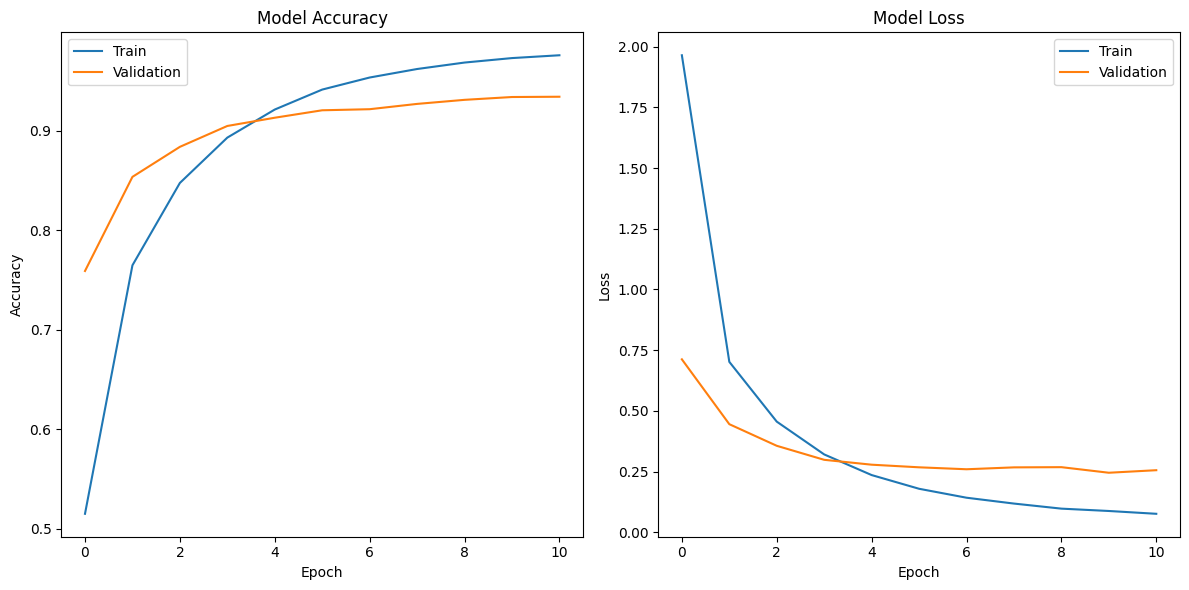

In [10]:

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


In [12]:
valid_loss, valid_accuracy = model.evaluate(dataset_val)

print(f"Valid Loss: {valid_loss}")
print(f"Valid Accuracy: {valid_accuracy}")

552/552 [==============================] - 5s 9ms/step - loss: 0.2555 - accuracy: 0.9340
Valid Loss: 0.25549179315567017
Valid Accuracy: 0.9339948892593384


In [13]:
test_loss, test_accuracy = model.evaluate(dataset_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

128/128 [==============================] - 1s 9ms/step - loss: 0.0343 - accuracy: 0.9912
Test Loss: 0.034343164414167404
Test Accuracy: 0.9912109375


## Evaluation Results and Analysis

We have successfully completed the training of our convolutional neural network (CNN) model and have evaluated its performance on the test dataset. The model achieved an impressive test accuracy of 99%, which exceeds our pre-defined threshold for success. This high level of accuracy indicates that the model is highly effective at classifying the instruments into the correct categories.

### Test Accuracy Achievement

The test accuracy serves as a critical measure of our model's generalization capabilities. Surpassing the threshold signifies not only the robustness of our model but also ensures that it meets the requirements for deployment in a production environment.

### Confusion Matrix Visualization

Next, we will visualize the performance details using a confusion matrix. The confusion matrix provides a granular view of the model's classification behavior by showing the true vs. predicted labels. This insight is particularly useful to identify any specific classes where the model may be confusing one label for another, despite the high overall accuracy.


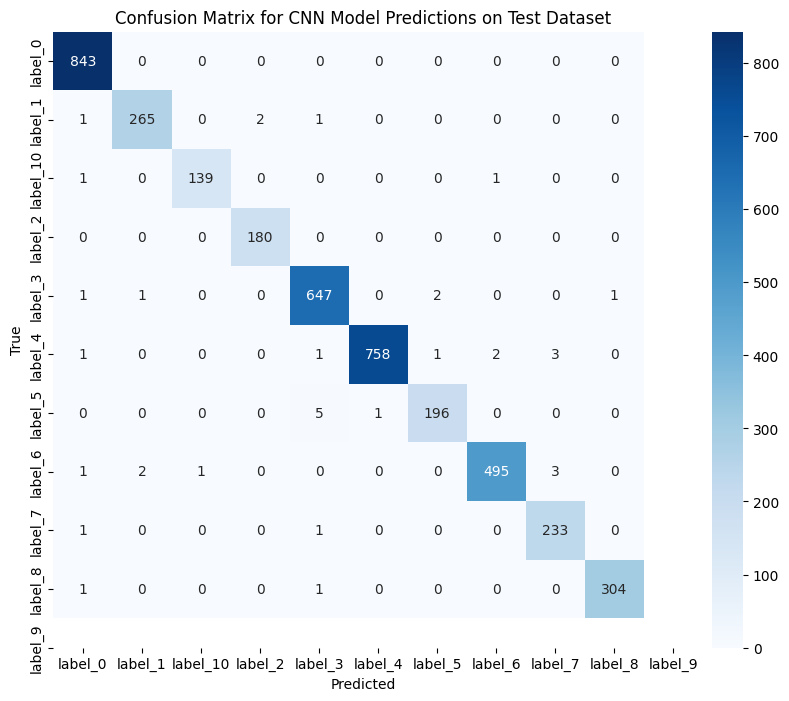

In [20]:

def plot_confusion_matrix(model, dataset, class_names):
    # Initialize the prediction and label lists(tensors)
    pred_labels = []
    true_labels = []

    for images, labels in dataset:
        # Predict the labels for the images from the validation dataset
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=1)

        # Append predicted and true labels
        pred_labels.extend(preds)
        true_labels.extend(np.argmax(labels.numpy(), axis=1))

    # Compute the confusion matrix using true and predicted labels
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix for CNN Model Predictions on Test Dataset")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Assuming you have a list of class names in the order they are indexed
class_names = dataset_val.class_names

# Plot the confusion matrix for the validation dataset
plot_confusion_matrix(model, dataset_test, class_names)


As we can see, the model got a excellent accuracy on our test data. Good enough to consider it done and use it for our next steps.

## Next Steps

* Create containers for easy deployment
* Deploy Model and test it on more unseen data, recorded naturally
* Create a genre classification model
* Deploy it in a Smart Home to create a companion musical app, that recognizes which instrument and genre you're playing and provides you with complementary music to harmonize.